In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import numpy as np


In [27]:
df = pd.read_csv('../data/datasetv2.csv')
df.columns

Index(['ticker', 'date', 'sent_raw', 'sent_weighted', 'sent_ewma_2',
       'sent_ewma_5', 'sent_ewma_10', 'followers_mean', 'tweet_count',
       'sent_mean', 'sent_median', 'sent_std', 'pos_share', 'neg_share',
       'neu_share', 'neg_sent_mean', 'extreme_neg_share', 'sent_mean_lag1',
       'sent_mean_change', 'neg_share_lag1', 'neg_share_change',
       'unique_users', 'avg_tweets_per_user', 'tweet_volume_change',
       'followers_median', 'followers_max', 'followers_weighted_sentiment',
       'followers_weighted_neg_share', 'past_ret_1d', 'past_ret_3d',
       'past_ret_5d', 'past_vol_5d', 'past_vol_10d', 'past_down_vol_5d',
       'past_up_vol_5d', 'daily_return', 'ret_3d', 'ret_5d', 'ret_7d',
       'label_5d_up'],
      dtype='object')

Point cloud shape: (10384, 3)


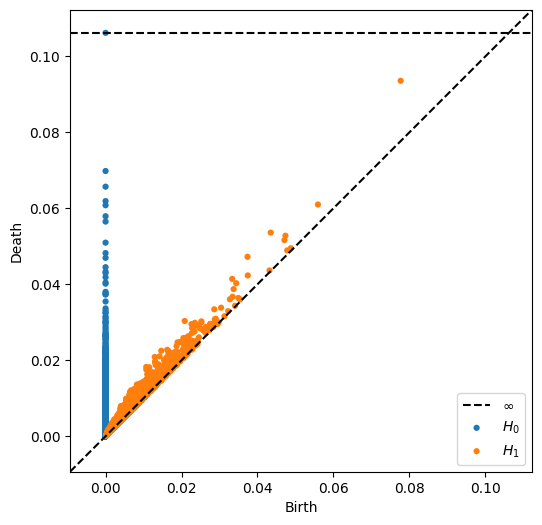


=== 3D TDA Results ===
H0 Total Persistence (clusters): 32.63555341477013
H1 Total Persistence (loops): 2.810242038583965


In [ ]:
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt

df.columns = df.columns.str.strip()

vol_col = 'past_vol_5d'

df3 = df[['sent_raw', vol_col, 'daily_return']].dropna()
X3 = df3.values

print("Point cloud shape:", X3.shape)


result3 = ripser(X3, maxdim=1)
diagrams3 = result3['dgms']


# ---------------------------------------------------------
plt.figure(figsize=(6,6))
plot_diagrams(diagrams3, show=True)


def finite_total_persistence(diagram):
    finite = diagram[np.isfinite(diagram[:,1])]
    return np.sum(finite[:,1] - finite[:,0])

H0_p3 = finite_total_persistence(diagrams3[0])
H1_p3 = finite_total_persistence(diagrams3[1])

print("\n=== 3D TDA Results ===")
print("H0 Total Persistence (clusters):", H0_p3)
print("H1 Total Persistence (loops):", H1_p3)


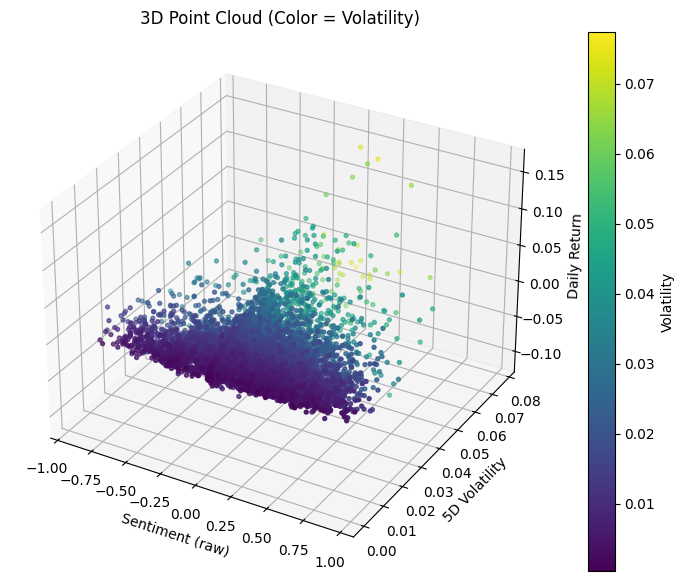

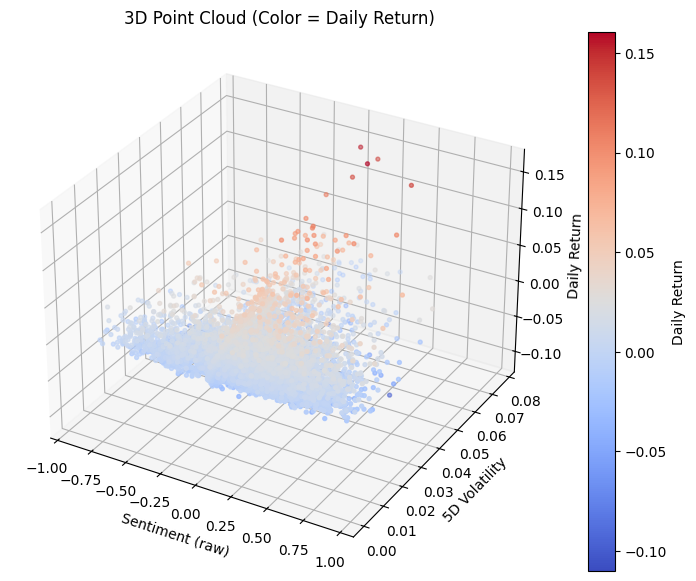

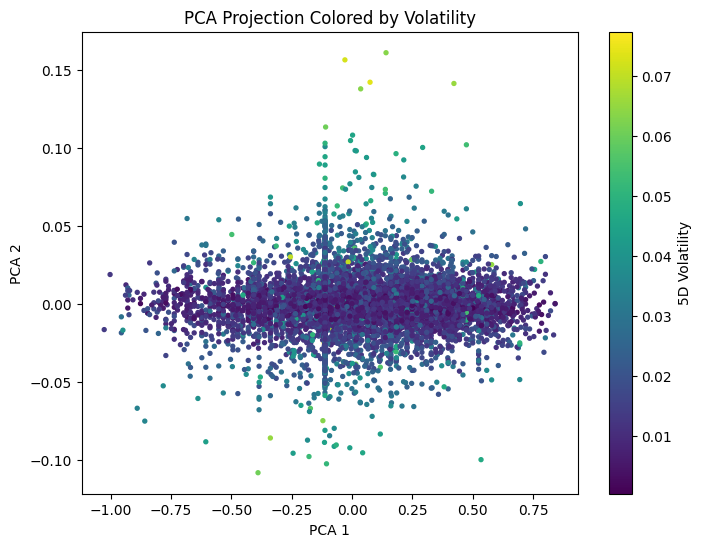

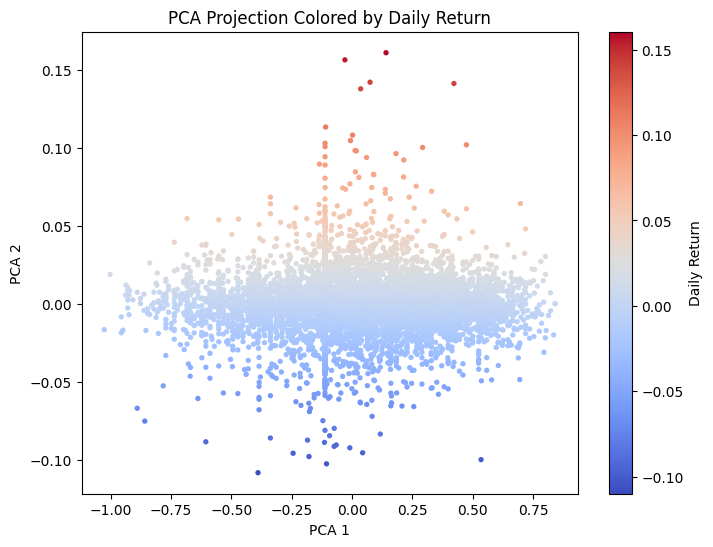

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA


df3 = df[['sent_raw', 'past_vol_5d', 'daily_return']].dropna()
X = df3.values

sent = df3['sent_raw'].values
vol = df3['past_vol_5d'].values
ret = df3['daily_return'].values


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(sent, vol, ret, c=vol, cmap='viridis', s=8)

ax.set_xlabel('Sentiment (raw)')
ax.set_ylabel('5D Volatility')
ax.set_zlabel('Daily Return')
ax.set_title('3D Point Cloud (Color = Volatility)')
fig.colorbar(p, label='Volatility')

plt.show()


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(sent, vol, ret, c=ret, cmap='coolwarm', s=8)

ax.set_xlabel('Sentiment (raw)')
ax.set_ylabel('5D Volatility')
ax.set_zlabel('Daily Return')
ax.set_title('3D Point Cloud (Color = Daily Return)')
fig.colorbar(p, label='Daily Return')

plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=vol, cmap='viridis', s=8)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA Projection Colored by Volatility')
plt.colorbar(label='5D Volatility')
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=ret, cmap='coolwarm', s=8)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA Projection Colored by Daily Return')
plt.colorbar(label='Daily Return')
plt.show()


In [30]:
import statsmodels.formula.api as smf

df_clean = df[['daily_return', 'sent_raw', 'past_vol_5d']].dropna()

model = smf.ols(
    "daily_return ~ sent_raw + past_vol_5d + sent_raw:past_vol_5d",
    data=df_clean
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           daily_return   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     26.41
Date:                Wed, 03 Dec 2025   Prob (F-statistic):           5.21e-17
Time:                        18:01:55   Log-Likelihood:                 27619.
No. Observations:               10384   AIC:                        -5.523e+04
Df Residuals:                   10380   BIC:                        -5.520e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0002 